### MLE

Parametric Model

Let the potential outcomes be given by,

$$ \begin{bmatrix} \log Y(0) \\\  \log Y(1)  \end{bmatrix} | T, \theta \sim N(\begin{bmatrix} \mu_c \\\  \mu_t \end{bmatrix}, \begin{bmatrix} \sigma^2_c \ 0  \\\  0 \  \sigma^2_t \end {bmatrix} )$$

where if $T$ is the treatment,

$$\mu_c = a_0$$
$$\mu_t = a_1 + \tau * T$$

Then ATE is,

$$ATE  = E[Y(1)-Y(0)] = r(\theta) = e^{\mu_t + 0.5\sigma^2_t} - e^{\mu_c + 0.5\sigma^2_c}$$

and $\theta = (\mu_c,\mu_t,\sigma_c,\sigma_t)$

The likelihood is given by,

$$L(\theta) = \prod_i f(y_i, t_i; \theta) = \prod_i f(y(1)|t_i)^{t_i} f(y(0)|t_i)^{1-t_i} $$

and log likelihood is,

$$l(\theta) = \sum_i \log f(y_i, t_i; \theta) = \sum_i t_i \log f(y(1)|t_i) + (1-t_i) \log f(y(0)|t_i) $$

where $f(y(1)|t_i, \theta) = \phi(\log y(1)|t_i, \theta)$, where $\phi$ is the normal pdf,

$$ = \sum_i t_i \log \phi(\log y(1)|t_i) + (1-t_i) \log \phi(\log y(0)|t_i) $$

and since, $y(1)=y$ if $t=1$ and $y(0)=y$ if $t=0$,

$$ = \sum_i t_i \log \phi(\log y_i|t_i) + (1-t_i) \log \phi(\log y_i|t_i) $$

we can maximize this to obtain $\hat{\theta}$ and values of the numerically computed Hessian at $\hat{\theta}$. That ensures asymptotic inference,

$$\sqrt{n}(\hat{\theta} - \theta) \sim_d N(0, \hat{H}(\hat{\theta})^{-1})$$


In [ ]:
N = 10000
np.random.seed(1234)
t = np.random.binomial(1,0.5,N)
e0 = np.random.normal(0,1,N)
e1 = np.random.normal(0,1,N)
a1 = a0 = -1
tau = 2
mu0 = a0
mu1 = a1 + tau * t
sig0 = 1
sig1 = 2
lny0 = mu0+sig0*e0
lny1 = mu1+sig1*e1
y0 = np.exp(lny0)
y1 = np.exp(lny1)
y = t*y1+(1-t)*y0
lny = np.round(np.log(y),4)
ate = np.exp(a1+tau+0.5*sig1**2)-np.exp(a0+0.5*sig0**2)
print(ate)

19.479006263475036


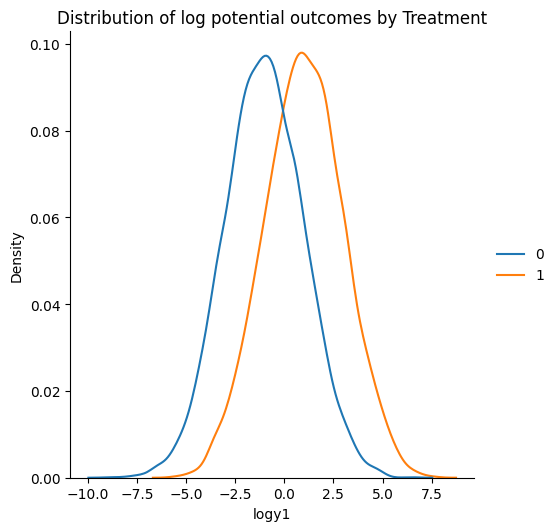

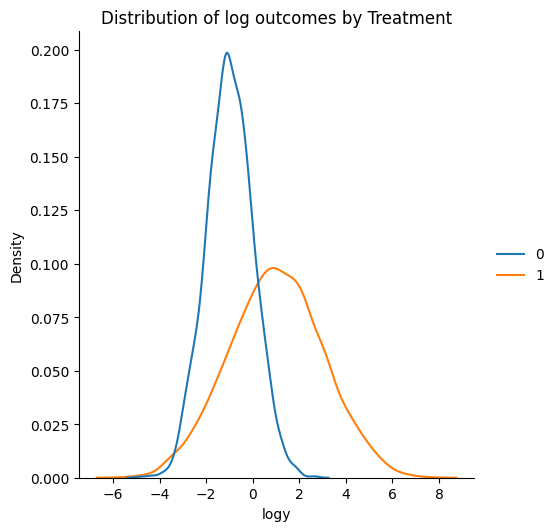

In [ ]:
import seaborn as sns

sns.displot(x=lny1, hue=t, kind="kde")
plt.title('Distribution of log potential outcomes by Treatment')
plt.xlabel('logy1')
plt.ylabel('Density')
plt.show()

sns.displot(x=lny, hue=t, kind="kde")
plt.title('Distribution of log outcomes by Treatment')
plt.xlabel('logy')
plt.ylabel('Density')
plt.show()

In [ ]:
from scipy.stats import norm
from scipy.optimize import minimize

def negloglik(theta):
    mu0 = theta[0]
    mu1 = theta[1]
    sig0 = theta[2]
    sig1 = theta[3]
    lny0_dist = norm(loc=mu0, scale=sig0)
    lny1_dist = norm(loc=mu1, scale=sig1)
    loss = -np.sum(t * np.log(lny1_dist.pdf(lny)+1e-8) + (1-t) * np.log(lny0_dist.pdf(lny)+1e-8))
    return loss

theta0 = np.array([-1,-2,1,2])
bounds = [(-3.0, 3.0), (-3.0, 3.0), (0, 3.0), (0, 3.0)]
res = minimize(negloglik, theta0, method='BFGS', tol=1e-2, bounds = bounds)

print(res)
print('Estimated Params:',res.x)
mu0_est,mu1_est,sig0_est,sig1_est = res.x
print('Estimated Std:', np.sqrt(res.hess_inv.diagonal()))
ate_est = np.exp(mu1_est+0.5*sig1_est**2)-np.exp(mu0_est+0.5*sig0_est**2)
print('Estimated ATE',ate_est)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 17704.58816118098
        x: [-9.895e-01  9.941e-01  1.006e+00  1.997e+00]
      nit: 14
      jac: [-1.709e-03 -9.766e-04  7.080e-03  4.883e-04]
 hess_inv: [[ 2.060e-04 -4.092e-06  1.466e-06 -1.311e-06]
            [-4.092e-06  7.556e-04  2.778e-06  2.382e-05]
            [ 1.466e-06  2.778e-06  9.724e-05  1.947e-07]
            [-1.311e-06  2.382e-05  1.947e-07  3.834e-04]]
     nfev: 105
     njev: 21
Estimated Params: [-0.9894818   0.99408136  1.00556038  1.99717218]
Estimated Std: [0.0143534  0.02748731 0.00986118 0.01958142]
Estimated ATE 19.238109804750383


In [ ]:
import numpy as np
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

class MaximumLikelihood(GenericLikelihoodModel):
    def loglike(self, params):
        mu0 = params[0]
        mu1 = params[1]
        sig0 = params[2]
        sig1 = params[3]
        lny0_dist = norm(loc=mu0, scale=sig0)
        lny1_dist = norm(loc=mu1, scale=sig1)
        loglikelihood = np.sum(t * np.log(lny1_dist.pdf(lny) + 1e-8) + (1 - t) * np.log(lny0_dist.pdf(lny) + 1e-8))
        return loglikelihood

theta0 = np.array([-1, -1.2, 1, 2])
model = MaximumLikelihood(lny, exog=np.ones(len(lny)))
result = model.fit(start_params=theta0)

print(result.params)
print(np.round(model.hessian(result.params),2))
print(result.summary())

Optimization terminated successfully.
         Current function value: 1.770459
         Iterations: 111
         Function evaluations: 189
[-0.98949402  0.99404861  1.00556159  1.99715008]
[[-4.90330e+03  0.00000e+00 -1.30000e-01  0.00000e+00]
 [ 0.00000e+00 -1.26410e+03  0.00000e+00 -4.00000e-02]
 [-1.30000e-01  0.00000e+00 -9.80653e+03  0.00000e+00]
 [ 0.00000e+00 -4.00000e-02  0.00000e+00 -2.52828e+03]]
                          MaximumLikelihood Results                           
Dep. Variable:                      y   Log-Likelihood:                -17705.
Model:              MaximumLikelihood   AIC:                         3.542e+04
Method:            Maximum Likelihood   BIC:                         3.545e+04
Date:                Tue, 09 Jan 2024                                         
Time:                        17:35:45                                         
No. Observations:               10000                                         
Df Residuals:                    999

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:2750: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:2754: UserWarning: df_resid differs from nobs - k_params
  warnings.warn("df_resid differs from nobs - k_params")


Standard Errors for ATE Est

- We know from ML estimation that the inverse of the Hessian $H$ evaluated at the optima (estimated theta), is the variance covariance matrix $V$ of the estimated theta.

- To connect it to the variance covariance matrix of the estimated ATE, we use the Delta method

- Delta Method: If a sequence $X_n$ satisfies, $\sqrt{n}(X_n - \theta) \sim_d N(0,\sigma^2)$, then we have,

$$\sqrt{n}(g(X_n) - g(\theta)) \sim_d N(0,\sigma^2 [g'(\theta)]^2)$$

- Multivariate Delta: if sequence vector $b$ satisfies, $\sqrt{n}(b - \theta) \sim_d N(0,\Sigma)$,
then we have,

$$\sqrt{n}(g(b) - g(\theta)) \sim_d N(0,\Delta g(\theta)' \Sigma \Delta g(\theta))$$

Let the parameter be,

$$ \theta = \begin{bmatrix} \mu_c \\ \mu_t \\ \sigma_c \\ \sigma_t \end{bmatrix}$$

and the $ATE$ is given by,

$$ATE = g(\theta) = e^{\mu_t + 0.5\sigma^2_t} - e^{\mu_c + 0.5\sigma^2_c}$$

then the gradients are,

$$ \Delta g(\theta) = \begin{bmatrix} - e^{\mu_c + 0.5\sigma^2_c} \\ e^{\mu_t + 0.5\sigma^2_t}\\ - \sigma_c e^{\mu_c + 0.5\sigma^2_c} \\ \sigma_t e^{\mu_t + 0.5\sigma^2_t}  \end{bmatrix}$$

thus, we use the numerical Hessian computed $\hat{H}$ to obtain $\hat{V}$ and then find the SE for ATE via,

$$\hat{V}_{ATE} = \Delta g(\hat{\theta})' \hat{V} \Delta g(\hat{\theta}) $$




In [ ]:
print('Estimated Theta',mu0_est,mu1_est,sig0_est,sig1_est)
V = res.hess_inv
print('Estimated Theta VARCOV', V)
Ey0 = np.exp(mu0_est + 0.5 * sig0_est**2)
Ey1 = np.exp(mu1_est + 0.5 * sig1_est**2)
delta_g = np.array([-Ey0, Ey1, -sig0_est*Ey0, sig1_est*Ey1])
V_ATE = np.dot(delta_g.T, np.dot(V, delta_g))
print(V_ATE)
print('Estimated ATE VARCOV', V_ATE)

Estimated Theta -0.9894818038191056 0.9940813641799424 1.0055603831783744 1.9971721802885376
Estimated Theta VARCOV [[ 2.06020201e-04 -4.09231172e-06  1.46570345e-06 -1.31123283e-06]
 [-4.09231172e-06  7.55552248e-04  2.77781732e-06  2.38180904e-05]
 [ 1.46570345e-06  2.77781732e-06  9.72428716e-05  1.94718045e-07]
 [-1.31123283e-06  2.38180904e-05  1.94718045e-07  3.83432052e-04]]
0.9384331915776908
Estimated ATE VARCOV 0.9384331915776908


In [ ]:
N = 10000
np.random.seed(1234)
t = np.random.binomial(1,0.5,N)
e0 = np.random.normal(0,1,N)
e1 = np.random.normal(0,1,N)
a1 = a0 = -1
tau = 2
mu0 = a0
mu1 = a1 + tau * t
sig0 = 1
sig1 = 2
lny0 = mu0+sig0*e0
lny1 = mu1+sig1*e1
y0 = np.exp(lny0)
y1 = np.exp(lny1)
y = t*y1+(1-t)*y0
lny = np.round(np.log(y),4)
ate = np.exp(a1+tau+0.5*sig1**2)-np.exp(a0+0.5*sig0**2)
print(ate)

from scipy.stats import norm
from scipy.optimize import minimize

def negloglik(theta):
    mu0 = theta[0]
    mu1 = theta[1]
    sig0 = theta[2]
    sig1 = theta[3]
    lny0_dist = norm(loc=mu0, scale=sig0)
    lny1_dist = norm(loc=mu1, scale=sig1)
    loss = -np.sum(t * np.log(lny1_dist.pdf(lny)+1e-8) + (1-t) * np.log(lny0_dist.pdf(lny)+1e-8))
    return loss

theta0 = np.array([-1,-2,1,2])
bounds = [(-3.0, 3.0), (-3.0, 3.0), (0, 3.0), (0, 3.0)]
res = minimize(negloglik, theta0, method='BFGS', tol=1e-2, bounds = bounds)

print(res)
print('Estimated Params:',res.x)
mu0_est,mu1_est,sig0_est,sig1_est = res.x
print('Estimated Std:', np.sqrt(res.hess_inv.diagonal()))
ate_est = np.exp(mu1_est+0.5*sig1_est**2)-np.exp(mu0_est+0.5*sig0_est**2)
print('Estimated ATE',ate_est)

print('Estimated Theta',mu0_est,mu1_est,sig0_est,sig1_est)
V = res.hess_inv
print('Estimated Theta VARCOV', V)
Ey0 = np.exp(mu0_est + 0.5 * sig0_est**2)
Ey1 = np.exp(mu1_est + 0.5 * sig1_est**2)
delta_g = np.array([-Ey0, Ey1, -sig0_est*Ey0, sig1_est*Ey1])
V_ATE = np.dot(delta_g.T, np.dot(V, delta_g))
print(V_ATE)
print('Estimated ATE VARCOV', V_ATE)

19.479006263475036


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 17704.58816118098
        x: [-9.895e-01  9.941e-01  1.006e+00  1.997e+00]
      nit: 14
      jac: [-1.709e-03 -9.766e-04  7.080e-03  4.883e-04]
 hess_inv: [[ 2.060e-04 -4.092e-06  1.466e-06 -1.311e-06]
            [-4.092e-06  7.556e-04  2.778e-06  2.382e-05]
            [ 1.466e-06  2.778e-06  9.724e-05  1.947e-07]
            [-1.311e-06  2.382e-05  1.947e-07  3.834e-04]]
     nfev: 105
     njev: 21
Estimated Params: [-0.9894818   0.99408136  1.00556038  1.99717218]
Estimated Std: [0.0143534  0.02748731 0.00986118 0.01958142]
Estimated ATE 19.238109804750383


Checking Asymptotic Inferenece

- Simulate the data many times, to check the sampling distribution of estimated ATE.